There have been some studies done to measure the dielectric property of soil depending on volumetric water content. In their paper [Topp](Electromagnetic determination of soil water content Measurements in coaxial transmission lines.pdf), et al. proposed an empirical model for soil permittivity dependent on moisture content. This model is given by:
$$
	\epsilon_r = 3.03 + 9.3\theta + 146.0\theta^2 -76.7\theta^3
$$
where $\epsilon_r$ is the relative permittivity of the sample and $\theta$ is the volumetric water content in the soil. There are other empirical models, but this seems to be the most accurate.


## Soil content
For a perfect soil with spherical particles, the packing density of 70%. The rest can be either  air or water. Concentration of water >30% will result in a saturated soil content.

In [ ]:
% Define all required material properties:

%% Permittivity
soil.er = 3.03;
water.er = 80;
air.er = 1;

%% Velocity of EM waves in material
air.v = 2.98e9;
soil.v = air.v/sqrt(soil.er);
water.v = air.v/sqrt(water.er);

The propagation constant can be calculated as required can be calculated by:
$$
	\beta_{m} = \frac{\omega}{v_p}
				= \frac{\omega}{\frac{c}{\sqrt{\epsilon_r}}}
				= \beta_{air}\sqrt{\epsilon_r}
$$
where,
$\beta_m$ is the propagation constant in the dielectric,

$\beta_{air}$ is the propagation constant in vacuum/air,

$\omega$ is the frequency of the EM wave,

$c$ is the speed of light in vacuum/air and 

$\epsilon_r$ is the relative dielectric permittivity of the material.

In [2]:
%% Propagation constant at f = 2.45GHz
f = 2.45e9;
air.b = 2*pi*f/air.v;
soil.b = air.b*sqrt(soil.er);
water.b = air.b*sqrt(water.er);

In [3]:
%% Characteristic impedance of the material
air.imp = sqrt(4*pi*1e-7/8.8541878e-12);
soil.imp = air.imp/sqrt(soil.er);
water.imp = air.imp/sqrt(water.er);

%% Other nice things to have
air.name = "air";
air.num = 1;

soil.name = "soil";
soil.num = 2;

water.name = "water";
water.num = 3;

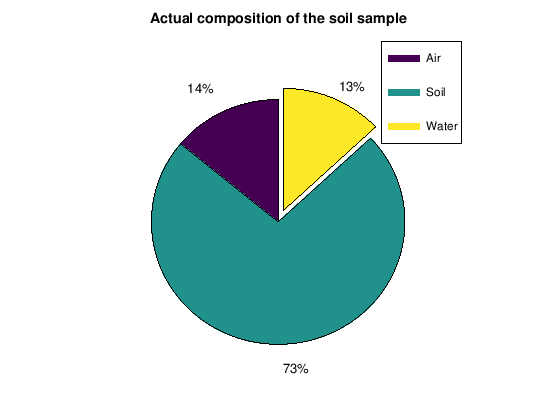

In [11]:
% Get a soil cross section depending on probability:

%% Number of particles to generate
DEPTH = 100;

%% Define total water content as a percentage with a max of 30%
WATER_CONTENT = 10;

content_count = zeros(1,3);

for i=1:DEPTH
    m = rand;
    if m > 0.30 
        mat = soil;
        content_count(soil.num) = content_count(soil.num) + 1;
        %display("Got soil")
    elseif m <= WATER_CONTENT/100
        mat = water;
        content_count(water.num) = content_count(water.num) + 1;
        %display("Got water");
    else 
        mat = air;
        content_count(air.num) = content_count(air.num) + 1;
        %display("Got air");
    endif
    soil_cs{i} = mat;
endfor

pie(content_count,[0,0,1]);
legend("Air","Soil","Water");
title("Actual composition of the soil sample")

In [12]:
% Print the first 10 slices
for i=1:20
    display(soil_cs{i}.name);
endfor

soil
soil
soil
soil
air
soil
soil
air
water
soil
air
soil
air
soil
soil
soil
soil
air
soil
soil


## Alternate ways to calculate bulk permittivity

Use multiple slab equation to calculate bulk reflection coefficient and then back calculate for $\epsilon_r$ 

$$
\Gamma_{bulk} = \Gamma_0 + \Gamma_1e^{-j2\beta_1d_1} + \Gamma_2e^{-j2(\beta_1d_1+\beta_2d_2)} + ... + \Gamma_ne^{-j2(\beta_1d_1+\beta_2d_2 + ... + \beta_n d_n)}
$$

### The program
   To do this in a programatic manner, we will loop through the soil cross section we generated above and calculate the reflection coeeficient at each boundary. We can calculate the reflection coefficient using the following formula:
   $$
       \Gamma_{1,2} = \frac{\eta_2-\eta_1}{\eta_2+\eta_1}
   $$
   where $\Gamma_{1,2}$ is the reflection coefficient of the boundary between materials 1 and 2, $\eta_1$ is the characteristic impedance of material 1 and $\eta_2$ is the characteristic impedance of material 2.

In [13]:
gamma(1) = (soil_cs{1}.imp - air.imp)/(soil_cs{1}.imp + air.imp);
for i=2:DEPTH
    gamma(i) = (soil_cs{i}.imp - soil_cs{i-1}.imp)/(soil_cs{i}.imp + soil_cs{i-1}.imp);
endfor

Similarly, lets calculate the exponents in the equation to make it easier and organised:

In [14]:
beta_sum = 0;
for i=2:DEPTH
    beta_sum(i) = beta_sum(i-1) + soil_cs{i}.b;
endfor

Putting everything together:

In [15]:
Gamma = 0;
for i=1:DEPTH
    Gamma = Gamma + gamma(i)*exp(-2*1j*beta_sum(i));
endfor

Then, 
$$
\Gamma_{bulk} = \frac{\eta_{bulk}-\eta_0}{\eta_{bulk}+\eta_0}
$$

Thus:
$$
	\eta_{bulk} = -\frac{\Gamma_{bulk} + 1}{\Gamma_{bulk} - 1}\eta_0
$$

In [16]:
imp_bulk = -(Gamma+1)*air.imp/(Gamma-1)

imp_bulk =   85.806 + 584.376i


Since we assumed that the permeability of the sample is 1. The permittivity is given by 
$$
    \epsilon_r = \frac{1}{\eta_{bulk}^2}
$$

In [17]:
er_bulk = (4*pi*1e-7/(imp_bulk^2))/8.8541878e-12
abs(er_bulk)

er_bulk = -0.3897 - 0.1170i
ans = 0.4068


## Assumptions made
- All particles are cubes
- All particles are the same size
- All particles are internally homogeneous
- All particles have relative permeability of 1